# 1. Using the trained model, find semantically similar words for other input words. Can you improve the results by tuning hyperparameters?

In [12]:
import time
import collections
import math
import os
import random
import torch
import warnings
import sys
import pandas as pd
import torch
import torch.nn as nn
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
warnings.filterwarnings("ignore")

#@save
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')
#@save
class RandomGenerator:
    """Randomly draw among {1, ..., n} according to n sampling weights."""
    def __init__(self, sampling_weights,k=10000):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0
        self.k = k

    def draw(self):
        if self.i == len(self.candidates):
            # Cache `k` random sampling results
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=self.k)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]
    
#@save
def subsample(sentences, vocab,flag=True):
    """Subsample high-frequency words."""
    # Exclude unknown tokens ('<unk>')
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = collections.Counter([
        token for line in sentences for token in line])
    num_tokens = sum(counter.values())

    # Return True if `token` is kept during subsampling
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))
    if flag:
        return ([[token for token in line if keep(token)] for line in sentences],
            counter)
    return (sentences,counter)

#@save
def get_centers_and_contexts(corpus, max_window_size):
    """Return center words and context words in skip-gram."""
    centers, contexts = [], []
    for line in corpus:
        # To form a "center word--context word" pair, each sentence needs to
        # have at least 2 words
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at `i`
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the center word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

#@save
def read_ptb():
    """Load the PTB dataset into a list of text lines."""
    data_dir = d2l.download_extract('ptb')
    # Read the training set
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

#@save
def get_negatives(all_contexts, vocab, counter, K, k=10000):
    """Return noise words in negative sampling."""
    # Sampling weights for words with indices 1, 2, ... (index 0 is the
    # excluded unknown token) in the vocabulary
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights,k)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

#@save
def batchify(data):
    """Return a minibatch of examples for skip-gram with negative sampling."""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words, flag=True, k=10000):
    """Download the PTB dataset and then load it into memory."""
    # num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab,flag)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words, k=k)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                      collate_fn=batchify)
    return data_iter, vocab

def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

def train(net, data_iter, lr, num_epochs, device='cpu'):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # Sum of normalized losses, no. of normalized losses
    metric = d2l.Accumulator(2)
    loss = SigmoidBCELoss()
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')
    return metric[0] / metric[1]

def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

loss 0.410, 55995.3 tokens/sec on cpu


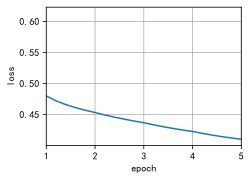

In [8]:
data_iter, vocab = load_data_ptb(512, 5, 5)
lr, num_epochs = 0.002, 5
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))
train(net, data_iter, lr, num_epochs)

loss 0.384, 36166.7 tokens/sec on cpu


0.3843912484866804

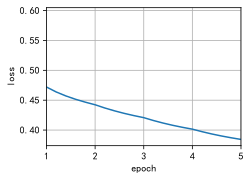

In [11]:
lr, num_epochs = 0.002, 5
embed_size = 200
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))
train(net, data_iter, lr, num_epochs)

In [14]:
get_similar_tokens('intel', 3, net[0])

cosine sim=0.551: workstations
cosine sim=0.537: microprocessor
cosine sim=0.525: compaq


# 2. When a training corpus is huge, we often sample context words and noise words for the center words in the current minibatch when updating model parameters. In other words, the same center word may have different context words or noise words in different training epochs. What are the benefits of this method? Try to implement this training method.

In [18]:
def get_centers_and_contexts(corpus, max_window_size):
    """Return center words and context words in skip-gram."""
    centers, contexts = [], []
    for line in corpus:
        # To form a "center word--context word" pair, each sentence needs to
        # have at least 2 words
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at `i`
            window_size = max_window_size
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the center word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

def batchify(data):
    """Return a minibatch of examples for skip-gram with negative sampling."""
    K = 5
    max_len = max(len(c)*(K+1) for _, c in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context in data:
        cur_len = len(context)
        centers += [center]
        contexts_negatives += [context + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

def load_data_ptb(batch_size, max_window_size, num_noise_words, flag=True, k=10000):
    """Download the PTB dataset and then load it into memory."""
    # num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab,flag)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    
    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts):
            assert len(centers) == len(contexts)
            self.centers = centers
            self.contexts = contexts

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                            collate_fn=batchify)
    return data_iter, vocab

def train(net, data_iter, lr, num_epochs, device='cpu'):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # Sum of normalized losses, no. of normalized losses
    metric = d2l.Accumulator(2)
    loss = SigmoidBCELoss()
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')
    return metric[0] / metric[1]

In [19]:
data_iter, vocab = load_data_ptb(512, 5, 5)

In [25]:
names = ['centers', 'contexts_negatives', 'masks', 'labels']
for batch in data_iter:
    a = batch[-1].sum(axis=1)
    # for name, data in zip(names, batch):
    #     print(name, 'shape:', data.shape)
    #     print(data[:1].sum(axis=1),data[:1])
    break

In [36]:
batch[-1].shape

torch.Size([512, 60])

In [28]:
b = torch.rand(a.shape)
b

tensor([0.5228, 0.1165, 0.1206, 0.0692, 0.6392, 0.7574, 0.2750, 0.5285, 0.0316,
        0.8961, 0.5254, 0.7293, 0.5075, 0.7108, 0.1085, 0.9266, 0.1018, 0.4557,
        0.1275, 0.9469, 0.4921, 0.3755, 0.9631, 0.5514, 0.7089, 0.1098, 0.9558,
        0.3481, 0.2059, 0.3001, 0.9712, 0.4838, 0.7545, 0.0689, 0.4741, 0.3387,
        0.4972, 0.1078, 0.5327, 0.0425, 0.1301, 0.1718, 0.4260, 0.2410, 0.2295,
        0.8053, 0.1328, 0.6618, 0.4904, 0.7540, 0.1522, 0.5649, 0.7417, 0.0132,
        0.4681, 0.8996, 0.9164, 0.8720, 0.2408, 0.8201, 0.3318, 0.5407, 0.1456,
        0.1821, 0.6699, 0.0753, 0.7358, 0.4351, 0.2425, 0.2990, 0.5337, 0.3591,
        0.1597, 0.6978, 0.6735, 0.6463, 0.2479, 0.2071, 0.0365, 0.9411, 0.6573,
        0.5754, 0.7111, 0.3198, 0.7388, 0.1517, 0.1285, 0.9861, 0.6654, 0.3752,
        0.3337, 0.5742, 0.1962, 0.7483, 0.5796, 0.5312, 0.8948, 0.8705, 0.1852,
        0.6663, 0.7238, 0.1565, 0.0927, 0.2251, 0.9005, 0.0303, 0.1905, 0.2911,
        0.7278, 0.6638, 0.6214, 0.5903, 

In [27]:
a

tensor([ 7,  6,  8, 10,  7,  3,  7,  6,  9,  5,  8,  8,  5,  9,  8,  5,  8,  6,
        10,  5, 10,  5,  8,  2,  6,  5,  7,  7,  7,  9,  5,  7,  6,  2,  9,  6,
         6,  7,  8,  6,  5, 10,  5,  7,  6,  9,  4,  5,  8,  5,  7,  5,  5,  5,
         5,  2, 10,  7,  6,  6,  8,  5,  8,  8,  5,  5,  9,  7,  5, 10,  5,  5,
         8,  9,  4,  7,  4,  1,  4,  4,  5, 10,  3, 10,  9,  5,  8,  5,  6, 10,
         5,  6,  7,  5,  7, 10,  5,  4,  6,  9,  8, 10,  6,  7,  9,  5,  8,  6,
         5,  4,  6,  9, 10,  5,  8,  6,  9, 10,  6,  6,  7,  3,  7,  6,  6,  2,
        10,  4,  7,  3,  4,  6,  5,  5,  8,  7,  7,  6,  6,  8,  3,  6,  8,  7,
         6,  5,  8,  9,  5,  7,  3,  7,  6, 10,  6,  6, 10,  2,  5,  5,  8,  8,
         7,  6,  4,  7,  6,  9, 10, 10, 10,  7,  6,  3,  7,  5,  5,  9,  9,  3,
         6,  8,  3, 10,  8,  7,  6,  7,  5,  5,  4,  6,  6,  5,  1,  5,  7,  8,
         9,  7,  5,  5,  7,  9,  7,  5,  1,  6, 10,  9,  7,  7,  6,  6,  5, 10,
        10,  9, 10, 10,  6,  6,  6,  3, 

In [38]:
c = torch.ceil(a*b)
c

tensor([ 4.,  1.,  1.,  1.,  5.,  3.,  2.,  4.,  1.,  5.,  5.,  6.,  3.,  7.,
         1.,  5.,  1.,  3.,  2.,  5.,  5.,  2.,  8.,  2.,  5.,  1.,  7.,  3.,
         2.,  3.,  5.,  4.,  5.,  1.,  5.,  3.,  3.,  1.,  5.,  1.,  1.,  2.,
         3.,  2.,  2.,  8.,  1.,  4.,  4.,  4.,  2.,  3.,  4.,  1.,  3.,  2.,
        10.,  7.,  2.,  5.,  3.,  3.,  2.,  2.,  4.,  1.,  7.,  4.,  2.,  3.,
         3.,  2.,  2.,  7.,  3.,  5.,  1.,  1.,  1.,  4.,  4.,  6.,  3.,  4.,
         7.,  1.,  2.,  5.,  4.,  4.,  2.,  4.,  2.,  4.,  5.,  6.,  5.,  4.,
         2.,  6.,  6.,  2.,  1.,  2.,  9.,  1.,  2.,  2.,  4.,  3.,  4.,  6.,
         2.,  4.,  7.,  1.,  2.,  1.,  4.,  2.,  6.,  3.,  4.,  6.,  5.,  1.,
         9.,  3.,  5.,  3.,  3.,  6.,  3.,  4.,  7.,  3.,  4.,  5.,  4.,  7.,
         1.,  5.,  2.,  1.,  1.,  5.,  5.,  5.,  1.,  6.,  1.,  1.,  6.,  4.,
         5.,  3.,  1.,  2.,  4.,  5.,  5.,  7.,  6.,  3.,  3.,  2.,  4.,  4.,
         5.,  8.,  2.,  4.,  3.,  1.,  7.,  4.,  3.,  7.,  3.,  

In [42]:
torch.tensor([1]*4+[0]*)

RuntimeError: The size of tensor a (4) must match the size of tensor b (10) at non-singleton dimension 1

In [46]:
d = torch.zeros(batch[-1].shape)
d

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [47]:
for i in range
    print(i)

tensor(4.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(5.)
tensor(3.)
tensor(2.)
tensor(4.)
tensor(1.)
tensor(5.)
tensor(5.)
tensor(6.)
tensor(3.)
tensor(7.)
tensor(1.)
tensor(5.)
tensor(1.)
tensor(3.)
tensor(2.)
tensor(5.)
tensor(5.)
tensor(2.)
tensor(8.)
tensor(2.)
tensor(5.)
tensor(1.)
tensor(7.)
tensor(3.)
tensor(2.)
tensor(3.)
tensor(5.)
tensor(4.)
tensor(5.)
tensor(1.)
tensor(5.)
tensor(3.)
tensor(3.)
tensor(1.)
tensor(5.)
tensor(1.)
tensor(1.)
tensor(2.)
tensor(3.)
tensor(2.)
tensor(2.)
tensor(8.)
tensor(1.)
tensor(4.)
tensor(4.)
tensor(4.)
tensor(2.)
tensor(3.)
tensor(4.)
tensor(1.)
tensor(3.)
tensor(2.)
tensor(10.)
tensor(7.)
tensor(2.)
tensor(5.)
tensor(3.)
tensor(3.)
tensor(2.)
tensor(2.)
tensor(4.)
tensor(1.)
tensor(7.)
tensor(4.)
tensor(2.)
tensor(3.)
tensor(3.)
tensor(2.)
tensor(2.)
tensor(7.)
tensor(3.)
tensor(5.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(4.)
tensor(4.)
tensor(6.)
tensor(3.)
tensor(4.)
tensor(7.)
tensor(1.)
tensor(2.)
tensor(5.)
tensor(4.)
tensor(4.)
tensor(2.